
<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy - SHAP model explainability</center></h2>
![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png)

In this work, I'll train a baseline ResNet50, evaluate the model, and use SHAP model explainability technique to help us better understand our model's predictions, and how we could further improve its performance.

#### About [SHAP](https://github.com/slundberg/shap) from its source:

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png" width="400">

##### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our [papers](https://github.com/slundberg/shap#citations) for details).

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 25.2 MB/s eta 0:00:00


## Dependencies

In [ ]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
# direktori dataset
dataset_path = "/content/drive/MyDrive/Dia"

## Load data

In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1170/1170 [00:22<00:00, 52.21it/s] 


In [ ]:
X_train,X_test = train_test_split(X_train, test_size=0.2,random_state=1010)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Diabetics/train',
                                              target_size = (224,224),
                                              batch_size=2,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=4,
                                              interpolation='bilinear'
                                              )

valid_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/Diabetics/val',
                                                   target_size=(224,224),
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=5,
                                                   interpolation='bilinear'
                                                   )

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Diabetics/test',
                                            target_size=(224,224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            )

Found 490 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## Train test split

In [ ]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=1010)

# Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

NameError: ignored

# Model

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, \
     MaxPool2D, Flatten, Dense

input = Input(shape=(224, 224, 3))

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=2, activation='softmax')(x)

In [ ]:
# Create model.
inputs = input
model =  keras.Model(inputs, x, name='VGG16')
model.summary()


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("VGG16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(train_generator,  
                    epochs=2,
                    validation_data = valid_generator,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/2
245/245 [==============================] - ETA: 0s - loss: 0.8480 - accuracy: 0.5041
Epoch 1: val_accuracy improved from -inf to 0.38462, saving model to VGG16.h5
245/245 [==============================] - 349s 1s/step - loss: 0.8480 - accuracy: 0.5041 - val_loss: 0.6994 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/2
245/245 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4837
Epoch 2: val_accuracy did not improve from 0.38462
245/245 [==============================] - 19s 76ms/step - loss: 0.6943 - accuracy: 0.4837 - val_loss: 0.6956 - val_accuracy: 0.3846 - lr: 0.0010


# Train top layers

# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models): 
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

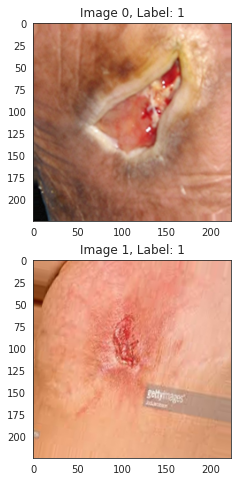

In [ ]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


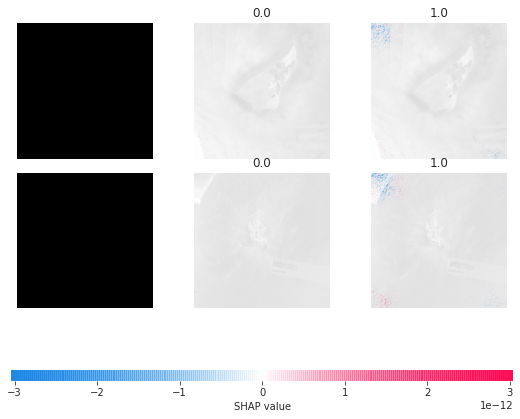

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

- The plot above explains five outputs (our five levels of diabetic retinopathy 0-5) for three different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left (they are black because most of the pixels are greater than 0), and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset, here I'm using 10 images) and the current model output. 
- Note that for the images that the label is "1.0" (the correct one), we a greater pink area.
- Labels that have as much pink area as the correct one are labels that our model probably doesn't have a high confidence prediction.

In [ ]:
import matplotlib.pyplot as plt

## Let's try on a few more images

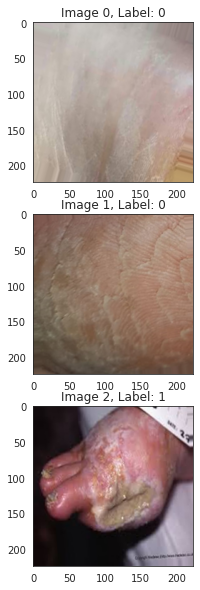

In [ ]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[10, 10])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


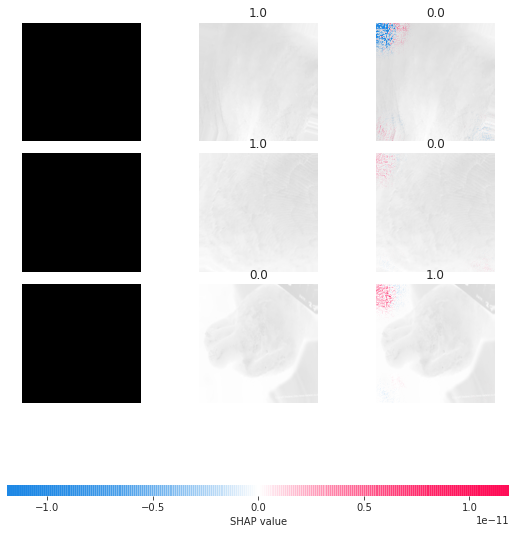

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)